In [1]:
# Import Pustaka Utama
!pip install -q google-play-scraper Sastrawi wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import csv
from io import StringIO
import requests
import nltk
from google_play_scraper import app, reviews, Sort, reviews_all
import joblib

# Pustaka NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource

# Pustaka Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Pustaka Visualisasi
from wordcloud import WordCloud

# Pustaka Scikit-learn (SKLearn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pustaka TensorFlow (Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer

# Import untuk model ML
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

# Mengatur Opsi
pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Data loading
df=pd.read_csv('dataset_aplikasi_dana.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,22a4fe3b-6762-47f8-9790-6dceed09819a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sudah setahun memang ga aktifin dana karenan h...,5,135,2.101.1,2025-10-23 18:29:44,"Hi Kak Alif, kami mengerti keluhan kakak menge...",2025-10-24 00:38:36,2.101.1
1,c789d3f4-0529-4cf2-b44a-b54881223991,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kecewa sih sama apk ini padahal biasanya serin...,1,20,2.101.1,2025-10-21 20:42:02,"Hi Kak Vera, kami mengerti kekecewaan kakak te...",2025-10-22 01:50:39,2.101.1
2,f413b9d9-8484-4cc1-bc5b-ee412f849761,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bintang 2 dulu, karena baru juga download.. lo...",2,201,2.99.1,2025-10-08 17:55:24,"Hi Kak Putra, kami siap membantu menyelesaikan...",2025-10-08 19:15:30,2.99.1
3,2895e752-3307-41a7-afb6-ec440c290df8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa mau pemindahan akun dari nomor lama ke ...,1,10,2.101.1,2025-10-24 16:51:00,"Hi Kak Ratna, maaf ya atas kendala terkait tid...",2025-10-24 23:27:09,2.101.1
4,7a26010d-7d1c-46fd-9007-b3829f66b878,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya yakin banyak yang mengeluhkan terkait nom...,1,9,2.101.1,2025-10-22 01:15:43,"Hi Kak, maaf ya bikin nuggu lama terkait nomor...",2025-10-22 03:06:54,2.101.1


In [ ]:
# Menampilkan informasi DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67694 entries, 0 to 67693
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              67694 non-null  object
 1   userName              67694 non-null  object
 2   userImage             67694 non-null  object
 3   content               67694 non-null  object
 4   score                 67694 non-null  int64 
 5   thumbsUpCount         67694 non-null  int64 
 6   reviewCreatedVersion  67694 non-null  object
 7   at                    67694 non-null  object
 8   replyContent          67694 non-null  object
 9   repliedAt             67694 non-null  object
 10  appVersion            67694 non-null  object
dtypes: int64(2), object(9)
memory usage: 5.7+ MB


In [ ]:
# Memeriksa nilai null
df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,0
at,0
replyContent,0
repliedAt,0


In [ ]:
# Memeriksa duplikat
df.duplicated().sum()

np.int64(0)

In [ ]:
# Fungsi Preprocessing Teks
def cleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\\s]', '', text)
    text = re.sub(r"http\\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefolding(text):
    text = text.lower()
    return text

def tokenisasi(text):
    text = word_tokenize(text)
    return text

def filtering(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
# Slangword
slangwords = pd.read_csv('kamus_alay.csv', header=None, names=['slang', 'formal'], encoding='latin-1')
slangwords = dict(zip(slangwords.slang, slangwords.formal))
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Menerapkan Preprocessing Teks
df['text_clean'] = df['content'].apply(cleaning)
df['text_casefoldingText'] = df['text_clean'].apply(casefolding)
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenisasi)
df['text_stopword'] = df['text_tokenizingText'].apply(filtering)
df['text_final'] = df['text_stopword'].apply(toSentence)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_final
0,22a4fe3b-6762-47f8-9790-6dceed09819a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sudah setahun memang ga aktifin dana karenan h...,5,135,2.101.1,2025-10-23 18:29:44,"Hi Kak Alif, kami mengerti keluhan kakak menge...",2025-10-24 00:38:36,2.101.1,sudah setahun memang ga aktifin dana karenan h...,sudah setahun memang ga aktifin dana karenan h...,sudah setahun memang enggak aktifin dana karen...,"[sudah, setahun, memang, enggak, aktifin, dana...","[setahun, aktifin, dana, karenan, hp, mati, pi...",setahun aktifin dana karenan hp mati pindah pe...
1,c789d3f4-0529-4cf2-b44a-b54881223991,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kecewa sih sama apk ini padahal biasanya serin...,1,20,2.101.1,2025-10-21 20:42:02,"Hi Kak Vera, kami mengerti kekecewaan kakak te...",2025-10-22 01:50:39,2.101.1,kecewa sih sama apk ini padahal biasanya serin...,kecewa sih sama apk ini padahal biasanya serin...,kecewa sih sama aplikasi ini padahal biasanya ...,"[kecewa, sih, sama, aplikasi, ini, padahal, bi...","[kecewa, aplikasi, logout, pas, login, pin, ve...",kecewa aplikasi logout pas login pin verifikas...
2,f413b9d9-8484-4cc1-bc5b-ee412f849761,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Bintang 2 dulu, karena baru juga download.. lo...",2,201,2.99.1,2025-10-08 17:55:24,"Hi Kak Putra, kami siap membantu menyelesaikan...",2025-10-08 19:15:30,2.99.1,Bintang dulu karena baru juga download login ...,bintang dulu karena baru juga download login ...,bintang dulu karena baru juga download login a...,"[bintang, dulu, karena, baru, juga, download, ...","[bintang, download, login, aman, uang, masuk, ...",bintang download login aman uang masuk cepat e...
3,2895e752-3307-41a7-afb6-ec440c290df8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kenapa mau pemindahan akun dari nomor lama ke ...,1,10,2.101.1,2025-10-24 16:51:00,"Hi Kak Ratna, maaf ya atas kendala terkait tid...",2025-10-24 23:27:09,2.101.1,kenapa mau pemindahan akun dari nomor lama ke ...,kenapa mau pemindahan akun dari nomor lama ke ...,kenapa mau pemindahan akun dari nomor lama ke ...,"[kenapa, mau, pemindahan, akun, dari, nomor, l...","[pemindahan, akun, nomor, nomor, minggu, kemar...",pemindahan akun nomor nomor minggu kemarin gag...
4,7a26010d-7d1c-46fd-9007-b3829f66b878,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya yakin banyak yang mengeluhkan terkait nom...,1,9,2.101.1,2025-10-22 01:15:43,"Hi Kak, maaf ya bikin nuggu lama terkait nomor...",2025-10-22 03:06:54,2.101.1,saya yakin banyak yang mengeluhkan terkait nom...,saya yakin banyak yang mengeluhkan terkait nom...,saya yakin banyak yang mengeluhkan terkait nom...,"[saya, yakin, banyak, yang, mengeluhkan, terka...","[mengeluhkan, terkait, nomor, expired, menerim...",mengeluhkan terkait nomor expired menerima kod...


In [ ]:
# Memuat Lexicon Positif dan Negatif dari URL
lexicon_positif = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positif[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negatif = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negatif[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
# Fungsi Untuk Lexicon Bahasa Indonesia
def lexicon_indonesia(text_tokens):
    score = 0
    for word in text_tokens:
        if word in lexicon_positif:
            score = score + lexicon_positif[word]
        elif word in lexicon_negatif:
            score = score + lexicon_negatif[word]
    sentimen = ''
    if score > 0:
        sentimen = 'positif'
    elif score < 0:
        sentimen = 'negatif'
    else:
        sentimen = 'netral'

    return score, sentimen

In [ ]:
# Menerapkan Analisis Sentimen Lexicon
results = df['text_stopword'].apply(lexicon_indonesia)
results = list(zip(*results))
df['sentimen_score'] = results[0]
df['sentimen'] = results[1]
print(df['sentimen'].value_counts())

sentimen
positif    47752
negatif    16812
netral      3130
Name: count, dtype: int64


In [ ]:
# Visualisasi WordCloud
def tampilkan_wordcloud(judul, teks):

    wc = WordCloud(background_color="white",
                   width=800,
                   height=400,
                   max_words=100,
                   collocations=False)


    if not teks.strip():
        print(f"Tidak ada data untuk WordCloud: {judul}")
        return

    wc.generate(teks)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(judul, fontsize=16)
    plt.axis('off')
    plt.show()

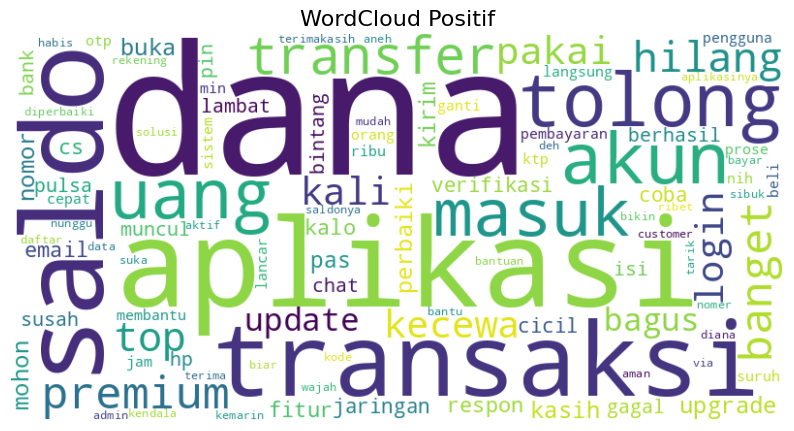

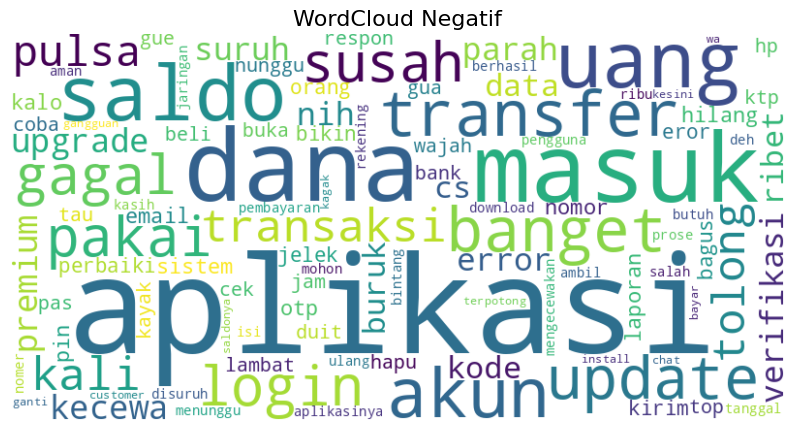

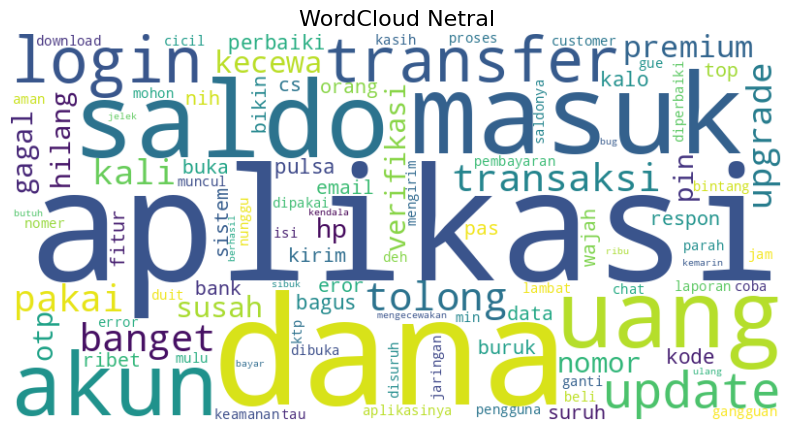

In [ ]:
# Menampilkan WordCloud untuk setiap Sentimen
text_positive = " ".join(df[df['sentimen'] == 'positif']['text_final'])
text_netral = " ".join(df[df['sentimen'] == 'netral']['text_final'])
text_negative = " ".join(df[df['sentimen'] == 'negatif']['text_final'])
tampilkan_wordcloud("WordCloud Positif", text_positive)
tampilkan_wordcloud("WordCloud Negatif", text_negative)
tampilkan_wordcloud("WordCloud Netral", text_netral)


In [ ]:
# Persiapan Data untuk Model dan Splitting Data Untuk Model ML Klasik
X = df['text_final']
y = df['sentimen']
tfidf = TfidfVectorizer(max_features=5000, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)

class_names = label_encoder.classes_
print(f"Nama Kelas: {class_names}")
print(f"Bentuk y_categorical: {y_categorical.shape}")

display(features_df)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

Nama Kelas: ['negatif' 'netral' 'positif']
Bentuk y_categorical: (67694, 3)


,abaikan,abal,acara,acc,account,adakah,adakan,adek,adik,adil,...,xl,yapadahal,yasaya,yaudah,youtube,yt,yth,yuk,zaman,zonk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Persiapan Data untuk Model Deep Learning
vocab_size = 10000
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Bentuk X_padded: {X_padded.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_categorical
)

y_test_labels = np.argmax(y_test, axis=1)

print(f"Data Latih: {X_train.shape}, {y_train.shape}")
print(f"Data Tes: {X_test.shape}, {y_test.shape}")

Bentuk X_padded: (67694, 100)
Data Latih: (54155, 100), (54155, 3)
Data Tes: (13539, 100), (13539, 3)


In [ ]:
# Fungsi Evaluasi Model Deep Learning
def evaluate_model(model, history, X_test, y_test, y_test_labels, class_names, model_name="Model"):
    print(f"--- MENAMPILKAN EVALUASI UNTUK: {model_name} ---")

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{model_name}_history_plot.png')
    plt.show()

    print(f"\n--- Evaluasi {model_name} pada Data Tes ---")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_test_labels, y_pred, target_names=class_names))

    print(f"\n--- {model_name} Confusion Matrix ---")
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    print("---------------------------------------------------\n")

In [ ]:
# Fungsi Evaluasi Model ML Klasik
def evaluate_ml_model(model, X_test, y_test, class_names, model_name="Model"):
    print(f"--- MENAMPILKAN EVALUASI UNTUK: {model_name} ---")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi: {accuracy:.4f}")
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print(f"\n--- {model_name} Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    try:
        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        plot_labels = model.classes_
    except:
        plot_labels = class_names

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=plot_labels, yticklabels=plot_labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    print("---------------------------------------------------\n")

In [ ]:
# Hyperparameter untuk Model Deep Learning
embedding_dim = 64
num_epochs = 10
batch_size = 128
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

--- Memulai Model Bidirectional LSTM ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,619 (2.87 MB)

 Trainable params: 751,619 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
381/381 - 125s - 327ms/step - accuracy: 0.8622 - loss: 0.3711 - val_accuracy: 0.9204 - val_loss: 0.2108
Epoch 2/10
381/381 - 113s - 297ms/step - accuracy: 0.9382 - loss: 0.1713 - val_accuracy: 0.9276 - val_loss: 0.2006
Epoch 3/10
381/381 - 112s - 294ms/step - accuracy: 0.9520 - loss: 0.1261 - val_accuracy: 0.9265 - val_loss: 0.2023
Epoch 4/10
381/381 - 129s - 337ms/step - accuracy: 0.9580 - loss: 0.1083 - val_accuracy: 0.9252 - val_loss: 0.2114
Epoch 5/10
381/381 - 119s - 312ms/step - accuracy: 0.9649 - loss: 0.0895 - val_accuracy: 0.9300 - val_loss: 0.2176
--- MENAMPILKAN EVALUASI UNTUK: Bidirectional LSTM ---


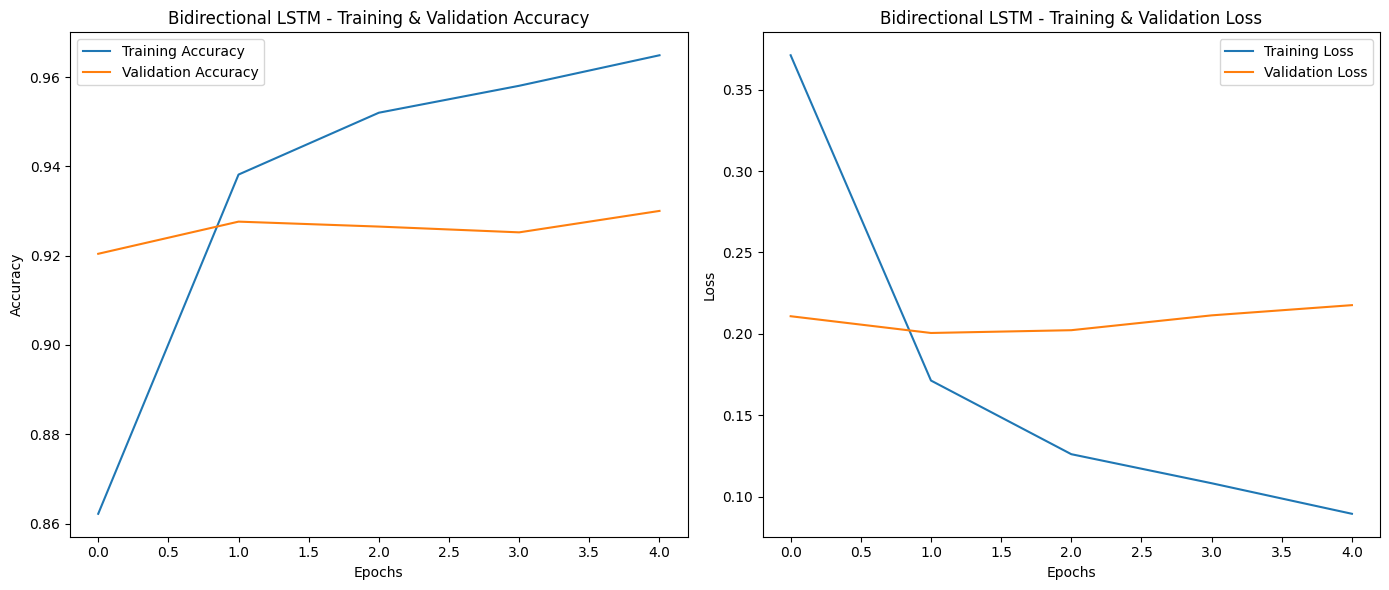


--- Evaluasi Bidirectional LSTM pada Data Tes ---
Test Loss: 0.2040
Test Accuracy: 0.9262
424/424 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step

--- Bidirectional LSTM Classification Report ---
              precision    recall  f1-score   support

     negatif       0.93      0.88      0.91      3362
      netral       0.55      0.27      0.36       626
     positif       0.94      0.98      0.96      9551

    accuracy                           0.93     13539
   macro avg       0.80      0.71      0.74     13539
weighted avg       0.92      0.93      0.92     13539


--- Bidirectional LSTM Confusion Matrix ---


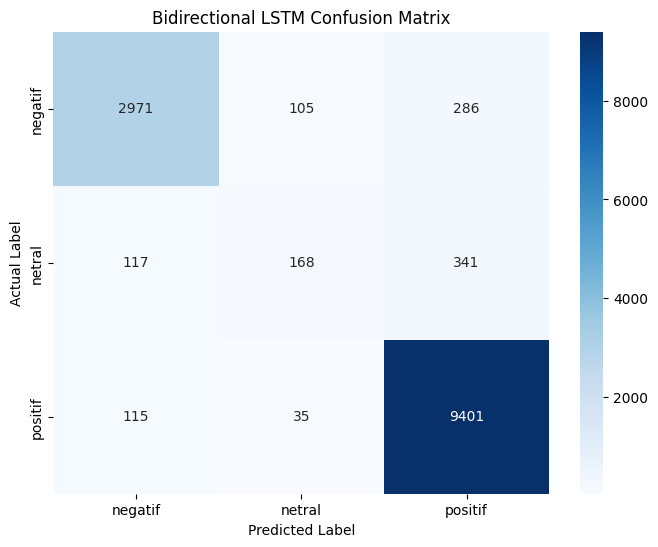

---------------------------------------------------



In [22]:
print("--- Memulai Model Bidirectional LSTM ---")
model_bilstm = Sequential()
model_bilstm.add(Input(shape=(max_length,)))
model_bilstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Bidirectional(LSTM(32)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(3, activation='softmax'))

model_bilstm.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

print(model_bilstm.summary())


history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)


evaluate_model(model_bilstm, history_bilstm, X_test, y_test, y_test_labels, class_names, model_name="Bidirectional LSTM")

--- Memulai Model Bidirectional GRU ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 128)       │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 725,379 (2.77 MB)

 Trainable params: 725,379 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
381/381 - 135s - 353ms/step - accuracy: 0.8645 - loss: 0.3632 - val_accuracy: 0.9186 - val_loss: 0.2261
Epoch 2/10
381/381 - 140s - 368ms/step - accuracy: 0.9382 - loss: 0.1729 - val_accuracy: 0.9247 - val_loss: 0.2104
Epoch 3/10
381/381 - 128s - 335ms/step - accuracy: 0.9504 - loss: 0.1318 - val_accuracy: 0.9241 - val_loss: 0.2216
Epoch 4/10
381/381 - 135s - 354ms/step - accuracy: 0.9566 - loss: 0.1140 - val_accuracy: 0.9243 - val_loss: 0.2190
Epoch 5/10
381/381 - 133s - 350ms/step - accuracy: 0.9609 - loss: 0.1001 - val_accuracy: 0.9215 - val_loss: 0.2441
--- MENAMPILKAN EVALUASI UNTUK: Bidirectional GRU ---


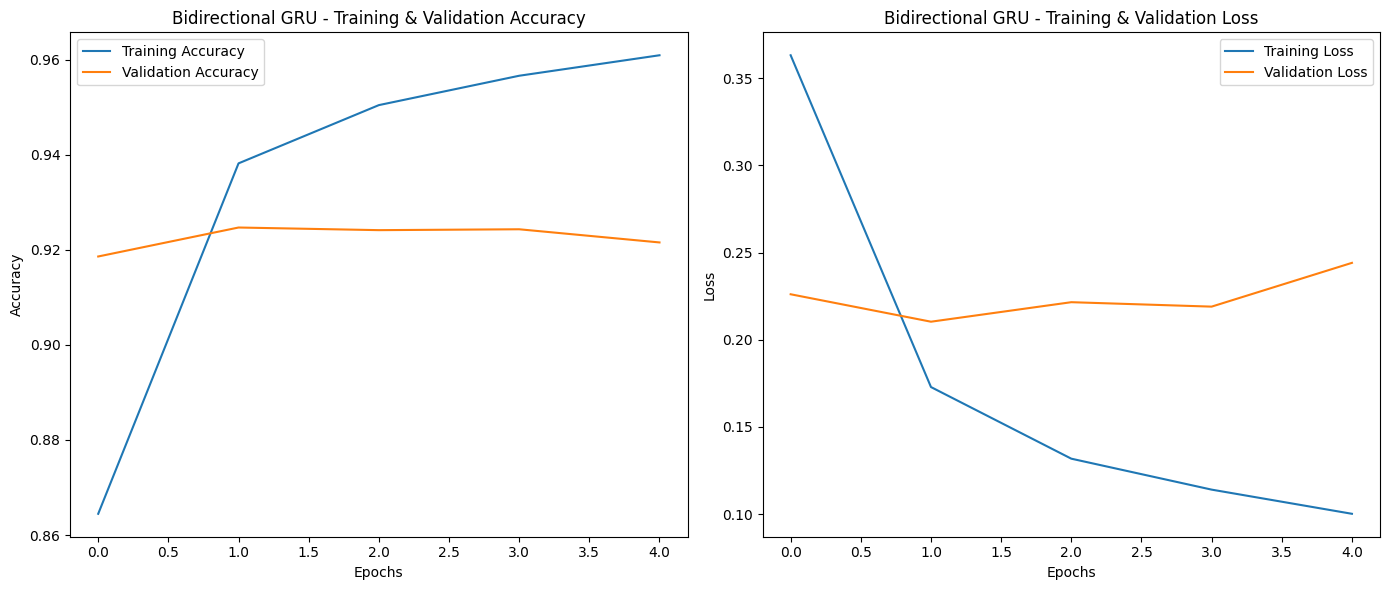


--- Evaluasi Bidirectional GRU pada Data Tes ---
Test Loss: 0.2097
Test Accuracy: 0.9234
424/424 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step

--- Bidirectional GRU Classification Report ---
              precision    recall  f1-score   support

     negatif       0.93      0.86      0.90      3362
      netral       0.64      0.26      0.37       626
     positif       0.93      0.99      0.96      9551

    accuracy                           0.92     13539
   macro avg       0.83      0.70      0.74     13539
weighted avg       0.92      0.92      0.91     13539


--- Bidirectional GRU Confusion Matrix ---


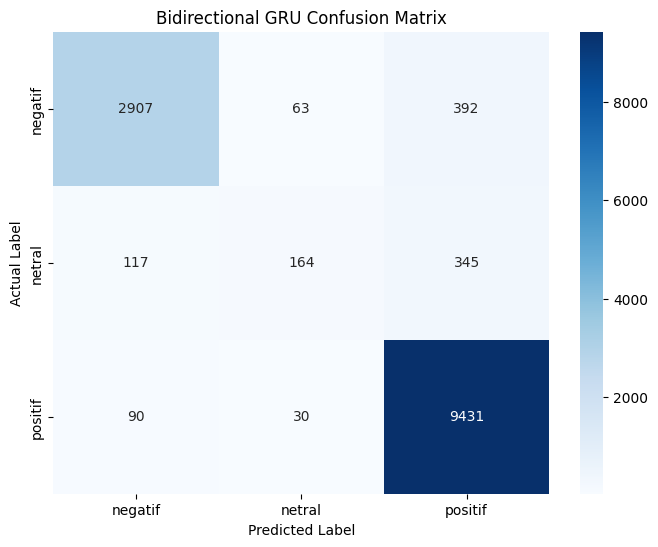

---------------------------------------------------



In [23]:
print("--- Memulai Model Bidirectional GRU ---")
model_gru = Sequential()
model_gru.add(Input(shape=(max_length,)))
model_gru.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model_gru.add(Bidirectional(GRU(64, return_sequences=True)))
model_gru.add(Dropout(0.3))
model_gru.add(Bidirectional(GRU(32)))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(3, activation='softmax'))

model_gru.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

print(model_gru.summary())


history_gru = model_gru.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

evaluate_model(model_gru, history_gru, X_test, y_test, y_test_labels, class_names, model_name="Bidirectional GRU")

--- Memulai Model Linear Support Vector Machine ---
Akurasi Data Training (SVM): 0.9505
--- MENAMPILKAN EVALUASI UNTUK: SVM ---
Akurasi: 0.9337

--- SVM Classification Report ---
              precision    recall  f1-score   support

     negatif       0.90      0.95      0.93      3344
      netral       0.81      0.04      0.08       657
     positif       0.94      0.99      0.97      9538

    accuracy                           0.93     13539
   macro avg       0.88      0.66      0.66     13539
weighted avg       0.93      0.93      0.91     13539


--- SVM Confusion Matrix ---


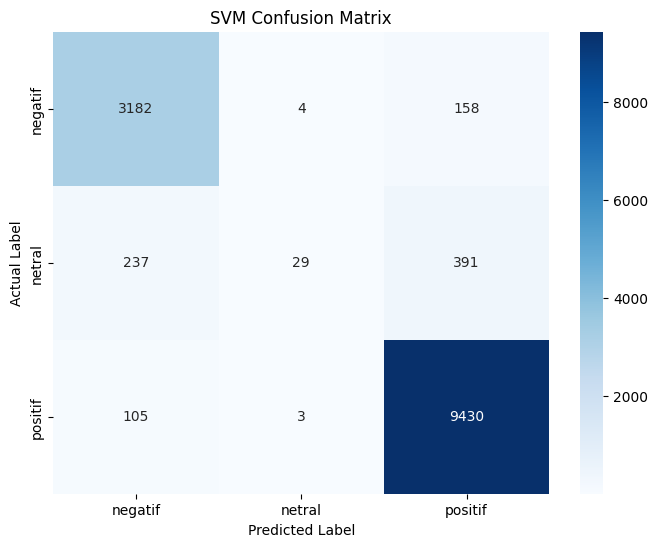

---------------------------------------------------



In [28]:
print("--- Memulai Model Linear Support Vector Machine ---")
model_svm = LinearSVC(random_state=42, max_iter=2000)
model_svm.fit(X_train_ml, y_train_ml)
y_pred_train_svc = model_svm.predict(X_train_ml)
print(f"Akurasi Data Training (SVM): {accuracy_score(y_train_ml, y_pred_train_svc):.4f}")
y_pred_svc = model_svm.predict(X_test_ml)
evaluate_ml_model(model_svm, X_test_ml, y_test_ml, class_names, model_name="SVM")

--- Memulai Model Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Akurasi Data Training (Logistic Regression): 0.9302
--- MENAMPILKAN EVALUASI UNTUK: Logistic Regression ---
Akurasi: 0.9146

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

     negatif       0.92      0.89      0.90      3344
      netral       1.00      0.01      0.02       657
     positif       0.91      0.99      0.95      9538

    accuracy                           0.91     13539
   macro avg       0.94      0.63      0.62     13539
weighted avg       0.92      0.91      0.89     13539


--- Logistic Regression Confusion Matrix ---


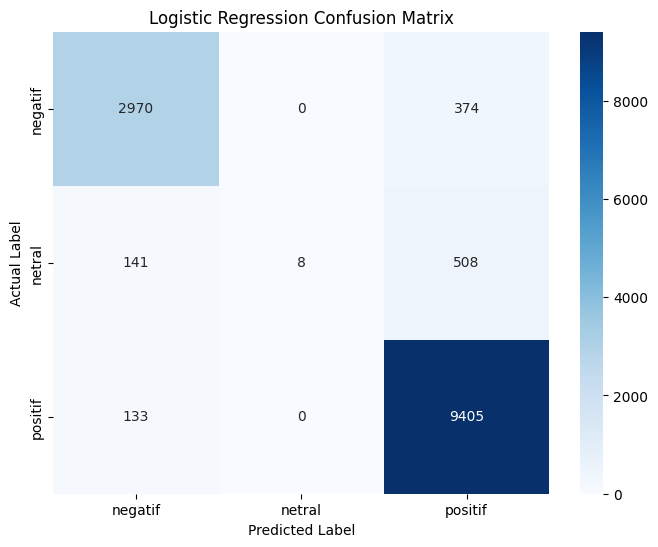

---------------------------------------------------



In [29]:
print("--- Memulai Model Logistic Regression ---")
model_lr = LogisticRegression(random_state=42, solver='liblinear', multi_class='ovr', max_iter=1000)
model_lr.fit(X_train_ml, y_train_ml)
y_pred_train_lr = model_lr.predict(X_train_ml)
print(f"Akurasi Data Training (Logistic Regression): {accuracy_score(y_train_ml, y_pred_train_lr):.4f}")
y_pred_lr = model_lr.predict(X_test_ml)
evaluate_ml_model(model_lr, X_test_ml, y_test_ml, class_names, model_name="Logistic Regression")

--- Memulai Model LightGBM (LGBM) Classifier ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.319099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119157
[LightGBM] [Info] Number of data points in the train set: 54155, number of used features: 2330
[LightGBM] [Info] Start training from score -1.391534
[LightGBM] [Info] Start training from score -3.086418
[LightGBM] [Info] Start training from score -0.348648


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Akurasi Data Training (LightGBM): 0.9042
--- MENAMPILKAN EVALUASI UNTUK: LightGBM ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Akurasi: 0.8642

--- LightGBM Classification Report ---
              precision    recall  f1-score   support

     negatif       0.83      0.74      0.78      3344
      netral       0.78      0.07      0.13       657
     positif       0.87      0.96      0.92      9538

    accuracy                           0.86     13539
   macro avg       0.83      0.59      0.61     13539
weighted avg       0.86      0.86      0.85     13539


--- LightGBM Confusion Matrix ---


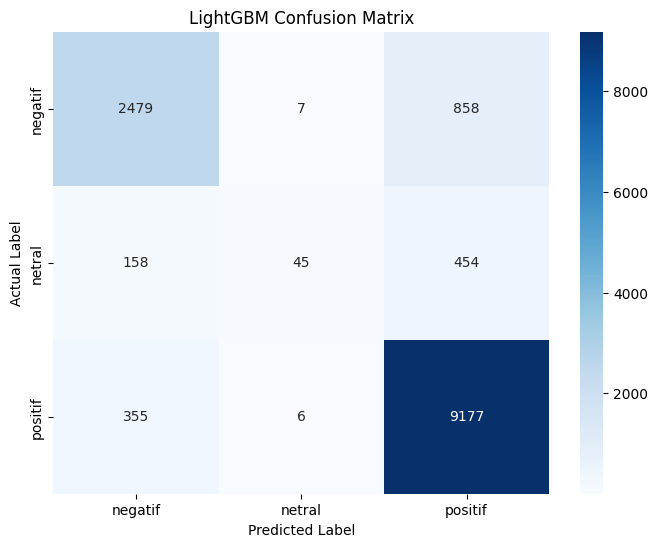

---------------------------------------------------



In [30]:
print("--- Memulai Model LightGBM (LGBM) Classifier ---")
model_lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
model_lgbm.fit(X_train_ml, y_train_ml)
y_pred_train_lgbm = model_lgbm.predict(X_train_ml)
print(f"Akurasi Data Training (LightGBM): {accuracy_score(y_train_ml, y_pred_train_lgbm):.4f}")
evaluate_ml_model(model_lgbm, X_test_ml, y_test_ml, class_names, model_name="LightGBM")

In [ ]:
print("Menyimpan model-model")

joblib.dump(model_bilstm, 'model_bilstm.joblib')
joblib.dump(model_gru, 'model_gru.joblib')
joblib.dump(model_svm, 'model_svm.joblib')
joblib.dump(model_lr, 'model_lr.joblib')
joblib.dump(model_lgbm, 'model_lgbm.joblib')

print("Menyimpan preprocessor...")


joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(label_encoder, 'label_encoder.joblib')
joblib.dump(slangwords, 'slangwords.joblib')

print("Semua model ML dan preprocessor berhasil disimpan.")


Menyimpan model-model Machine Learning...
Menyimpan preprocessor...
Semua model ML dan preprocessor berhasil disimpan.


In [ ]:
# Fungsi Preprocessing Teks untuk Prediksi
def preprocess_text(text):
    text_clean = cleaning(text)
    text_casefold = casefolding(text_clean)
    text_slang = fix_slangwords(text_casefold)
    text_tokens = tokenisasi(text_slang)
    text_filtered = filtering(text_tokens)
    text_final = toSentence(text_filtered)
    return text_final


def predict_all_models(raw_text):
    clean_text = preprocess_text(raw_text)
    if len(clean_text.strip()) == 0:
        print("Teks tidak valid (kosong setelah preprocessing).")
        return {model: "Tidak valid" for model in model_names}

    predictions = {}

    X_tfidf_new = tfidf.transform([clean_text])

    predictions["Linear SVM (SVC)"] = model_svm.predict(X_tfidf_new)[0]
    predictions["Logistic Regression"] = model_lr.predict(X_tfidf_new)[0]
    predictions["LightGBM"] = model_lgbm.predict(X_tfidf_new)[0]


    X_seq_new = tokenizer.texts_to_sequences([clean_text])
    X_pad_new = pad_sequences(X_seq_new, maxlen=100, padding='post', truncating='post')

    dl_models = {
        "Bidirectional LSTM": model_bilstm,
        "Bidirectional GRU": model_gru
    }

    for name, model in dl_models.items():
        pred_probs = model.predict(X_pad_new, verbose=0)
        pred_index = np.argmax(pred_probs, axis=1)[0]
        pred_label = label_encoder.inverse_transform([pred_index])[0]
        predictions[name] = pred_label

    return predictions

In [41]:
print("\n--- Sistem Prediksi Sentimen ---")
print("Ketik 'keluar' untuk berhenti.")

model_names = [
    "Linear SVM (SVC)",
    "Logistic Regression",
    "LightGBM",
    "Bidirectional LSTM",
    "Bidirectional GRU"
]

while True:
    user_input = input("\nMasukkan ulasan Anda: ")

    if user_input.lower() in [ 'keluar']:
        print("Terima kasih!")
        break

    results = predict_all_models(user_input)

    print("\n--- Hasil Prediksi ---")
    for model_name in model_names:
        print(f"{model_name:<25}: {results.get(model_name, 'Error')}")


--- Sistem Prediksi Sentimen ---
Ketik 'keluar' untuk berhenti.

Masukkan ulasan Anda: Aplikasi ini sangat buruk karena terjadi banyak bug


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Hasil Prediksi ---
Linear SVM (SVC)         : negatif
Logistic Regression      : negatif
LightGBM                 : negatif
Bidirectional LSTM       : negatif
Bidirectional GRU        : negatif

Masukkan ulasan Anda: Aplikasi ini sangat membantu saya dalam keuangan digital


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Hasil Prediksi ---
Linear SVM (SVC)         : positif
Logistic Regression      : positif
LightGBM                 : negatif
Bidirectional LSTM       : positif
Bidirectional GRU        : netral

Masukkan ulasan Anda: keluar
Terima kasih!
